<a href="https://colab.research.google.com/github/wave2503/assignment1/blob/main/Lec4/Lab6_result_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec4/Lab6_result_report.ipynb)를 통해 Colab에서 바로 작업하실 수 있습니다!  
런타임 유형은 python3, GPU 가속 확인하기!

In [2]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

## Data Preparation

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100%|██████████| 170M/170M [01:01<00:00, 2.75MB/s]


## Model Architecture

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier

        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

## Train, Validate, Test and Experiment

In [27]:
# train 함수
def train(net, trainloader, optimizer, criterion, args):
    net.train()
    correct = 0
    total = 0
    train_loss = 0.0

    # DataLoader 생성 코드 삭제! 바로 for문 시작
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()

        inputs, labels = data
        inputs = inputs.view(-1, 3072).cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

# validate 함수도 동일하게 valloader를 받도록 수정
def validate(net, valloader, criterion, args):
    net.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072).cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

# test 함수도 동일하게 testloader를 받도록 수정
def test(net, testloader, args):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072).cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [24]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [25]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [30]:
def experiment(partition, args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    # (Optimizer 설정 부분은 동일...)
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    # ====== [수정된 부분] 데이터 로더를 여기서 한 번만 생성! ====== #
    trainloader = torch.utils.data.DataLoader(partition['train'], batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=0, pin_memory=True)
    valloader = torch.utils.data.DataLoader(partition['val'], batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=0, pin_memory=True)
    testloader = torch.utils.data.DataLoader(partition['test'], batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=0, pin_memory=True)
    # ========================================================== #

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(args.epoch):
        ts = time.time()
        # 파티션 대신 미리 만든 로더를 전달합니다.
        net, train_loss, train_acc = train(net, trainloader, optimizer, criterion, args)
        val_loss, val_acc = validate(net, valloader, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, testloader, args)

    result = {}
    result['train_losses'] = train_losses
    # (나머지 result 저장 코드는 동일...)
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [12]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

In [55]:
sns.set_theme(style="darkgrid", font_scale=2.0)

# Manage Experiment Result

In [13]:
def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df


In [32]:
def get_gpu_dataloader(dataset, batch_size, shuffle):
    # 전체 데이터를 한 번에 불러옵니다 (이때만 시간이 조금 걸리고 이후엔 안 걸림)
    temp_loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    for images, labels in temp_loader:
        # 이미지를 한 번에 Flatten하고 GPU로 옮깁니다.
        images = images.view(-1, 3072).cuda()
        labels = labels.cuda()

        # 이미 GPU에 올라간 데이터로 TensorDataset을 만듭니다.
        gpu_dataset = torch.utils.data.TensorDataset(images, labels)

        # GPU 메모리 위에서 작동하는 DataLoader 반환
        return torch.utils.data.DataLoader(gpu_dataset, batch_size=batch_size, shuffle=shuffle)

In [33]:
def train(net, trainloader, optimizer, criterion, args):
    net.train()
    correct, total, train_loss = 0, 0, 0.0

    for inputs, labels in trainloader:
        # 이미 데이터가 GPU에 있으므로 .cuda(), .view() 모두 생략!!
        optimizer.zero_grad()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return net, train_loss / len(trainloader), 100 * correct / total


def validate(net, valloader, criterion, args):
    net.eval()
    correct, total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            # 여기서도 .cuda(), .view() 생략!!
            outputs = net(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(valloader), 100 * correct / total


def test(net, testloader, args):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            # 생략!!
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [34]:
def experiment(partition, args):
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2) # SGD 오타 수정!
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    # ======= 데이터 전체를 미리 GPU로 올리기 ======= #
    print("데이터를 GPU에 올리는 중입니다...")
    trainloader = get_gpu_dataloader(partition['train'], args.train_batch_size, True)
    valloader = get_gpu_dataloader(partition['val'], args.test_batch_size, False)
    testloader = get_gpu_dataloader(partition['test'], args.test_batch_size, False)
    print("준비 완료! 학습 시작!")
    # =============================================== #

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(args.epoch):
        ts = time.time()
        net, train_loss, train_acc = train(net, trainloader, optimizer, criterion, args)
        val_loss, val_acc = validate(net, valloader, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, testloader, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

## Experiment

In [56]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.n_layer = 5

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 512
args.test_batch_size = 10000

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [5,10,15,20]
list_var2 = [100, 200, 300, 400, 500, 600]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)

        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)


Namespace(exp_name='exp2_n_layer_hid_dim', in_dim=3072, out_dim=10, hid_dim=100, act='relu', n_layer=5, dropout=0.2, use_bn=True, l2=1e-05, use_xavier=True, optim='Adam', lr=0.0015, epoch=10, train_batch_size=512, test_batch_size=10000)
데이터를 GPU에 올리는 중입니다...
준비 완료! 학습 시작!
Epoch 0, Acc(train/val): 28.71/37.55, Loss(train/val) 1.97/1.72. Took 0.68 sec
Epoch 1, Acc(train/val): 38.23/42.07, Loss(train/val) 1.71/1.60. Took 0.68 sec
Epoch 2, Acc(train/val): 42.50/44.53, Loss(train/val) 1.61/1.54. Took 0.94 sec
Epoch 3, Acc(train/val): 45.13/46.38, Loss(train/val) 1.54/1.51. Took 0.66 sec
Epoch 4, Acc(train/val): 47.08/47.77, Loss(train/val) 1.48/1.46. Took 0.68 sec
Epoch 5, Acc(train/val): 48.73/48.66, Loss(train/val) 1.44/1.45. Took 0.68 sec
Epoch 6, Acc(train/val): 51.01/49.69, Loss(train/val) 1.38/1.43. Took 1.06 sec
Epoch 7, Acc(train/val): 51.89/50.07, Loss(train/val) 1.36/1.41. Took 1.01 sec
Epoch 8, Acc(train/val): 53.30/50.70, Loss(train/val) 1.32/1.40. Took 1.44 sec
Epoch 9, Acc(tra

In [52]:
!rm -rf ./results/*.json

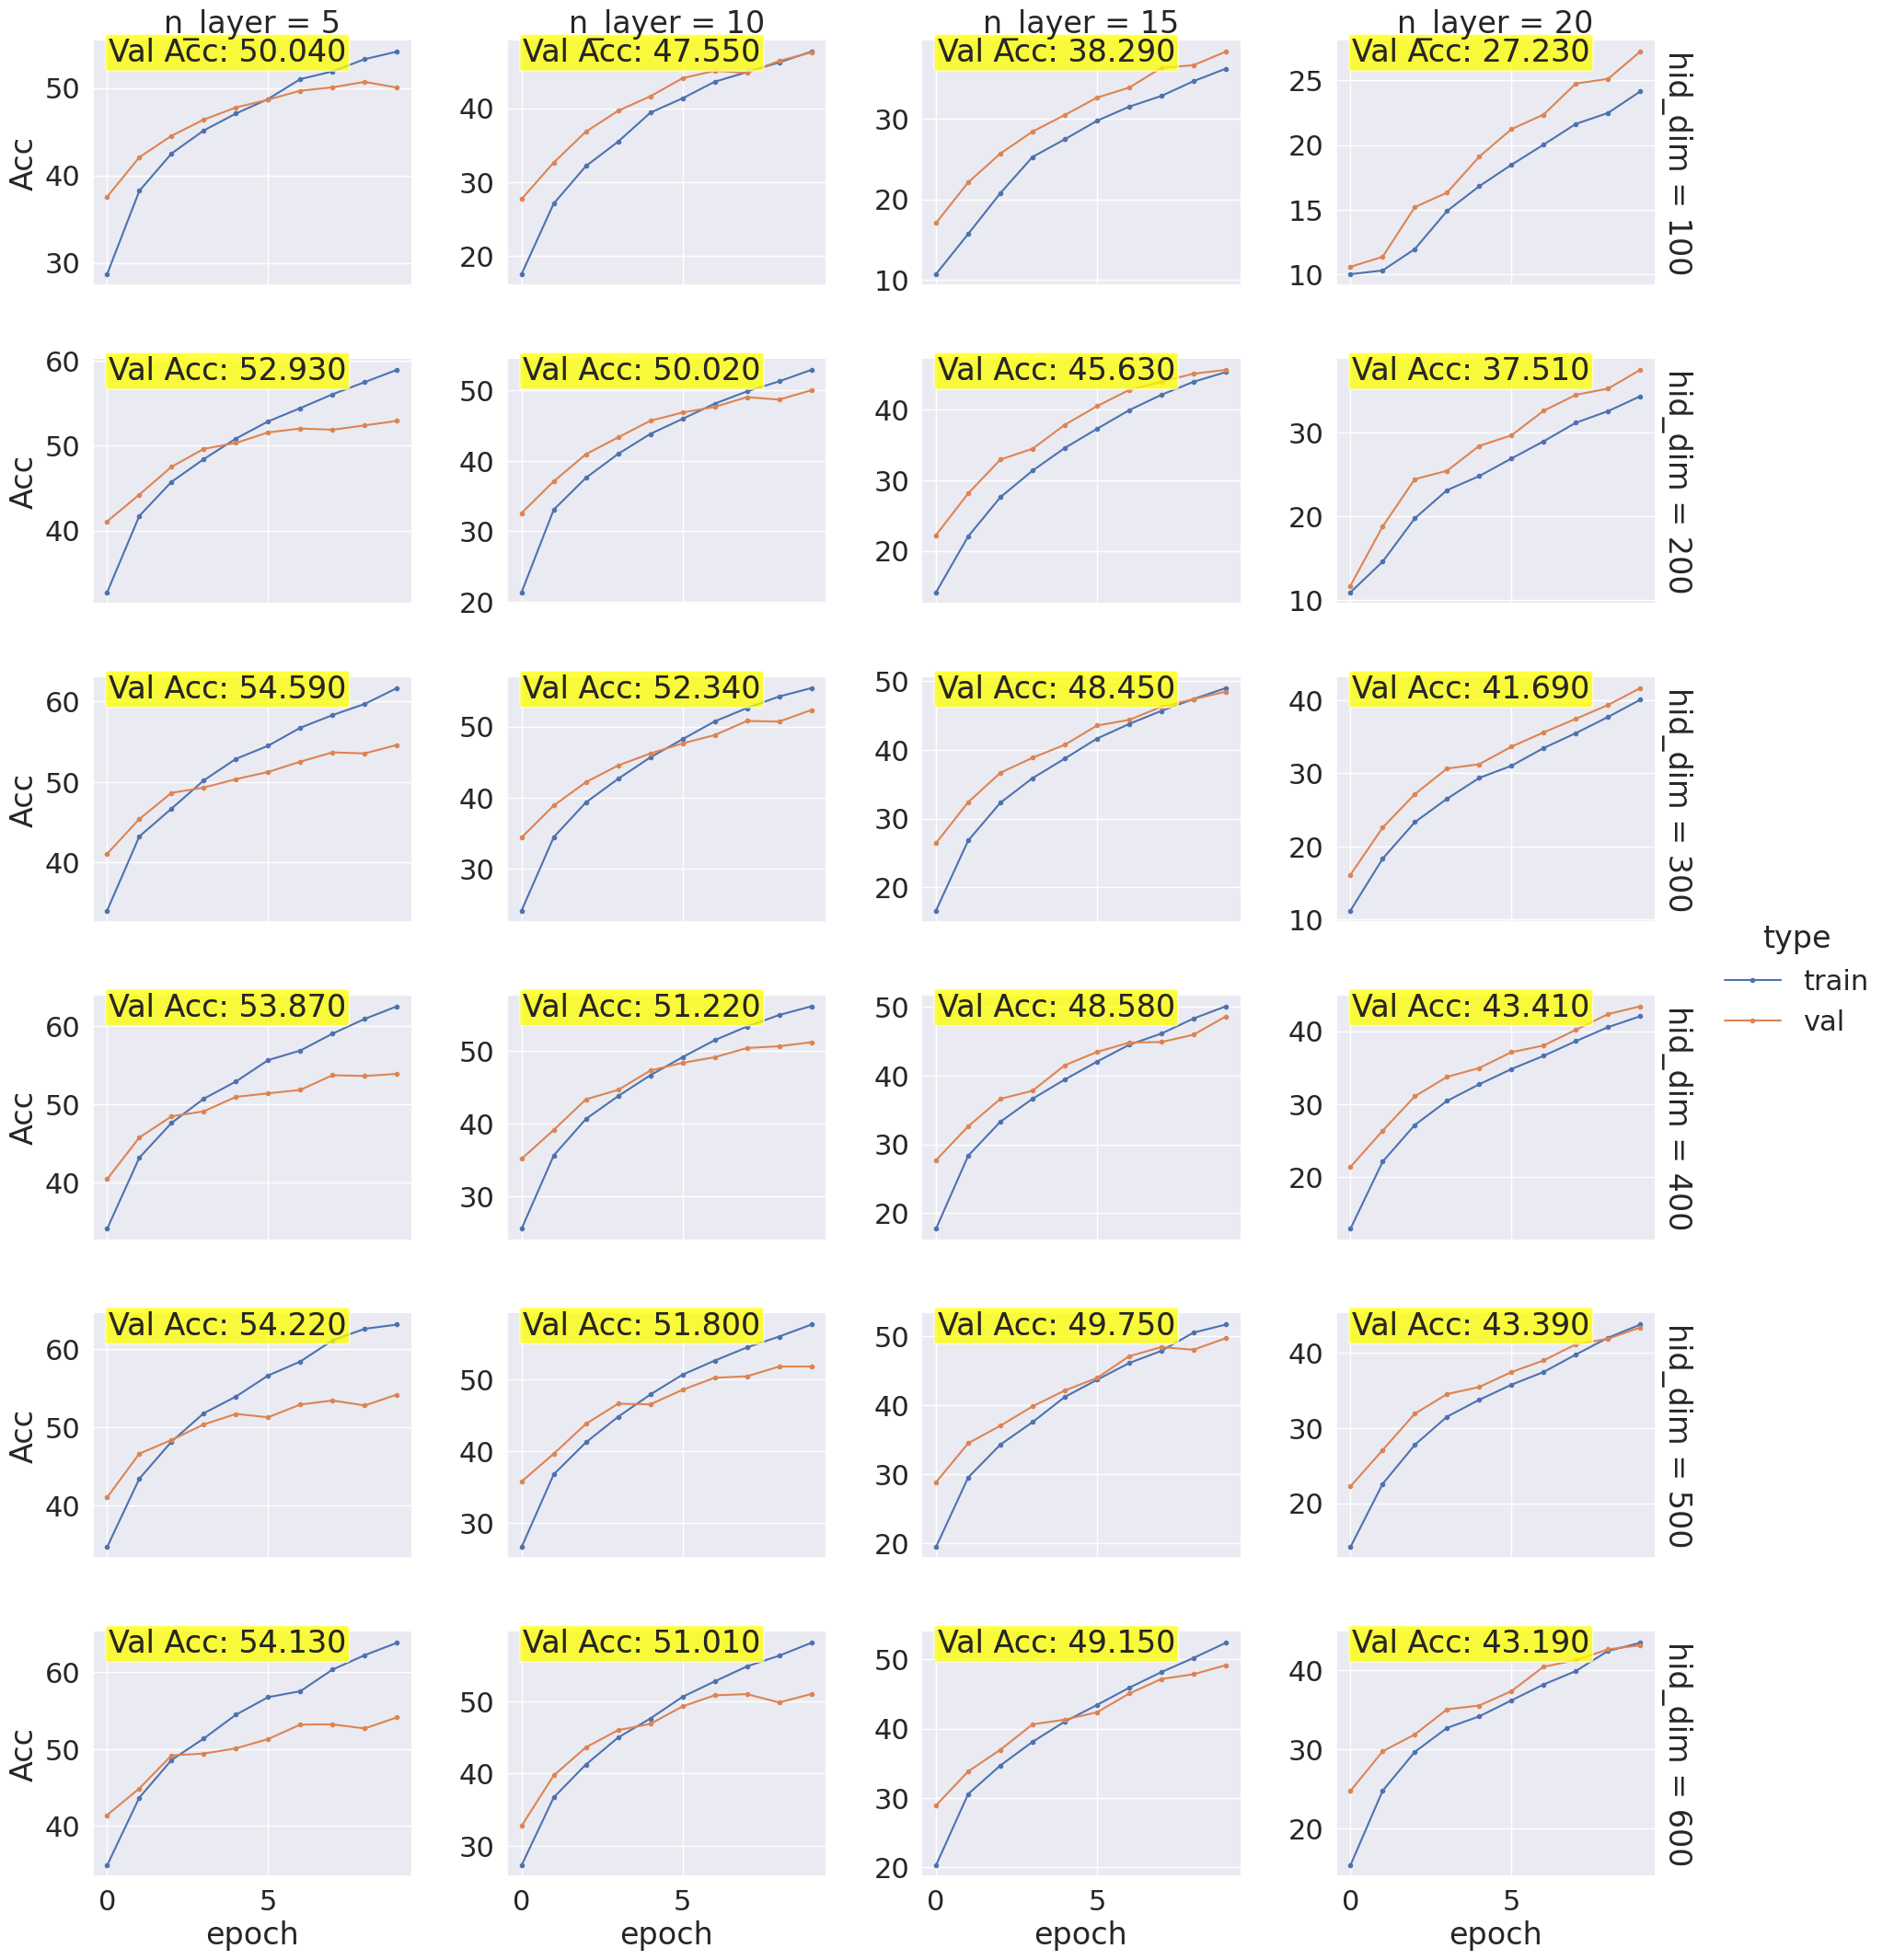

In [57]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        final_val_acc = list(row.val_acc)[0]

        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'final_val_acc':final_val_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'final_val_acc':final_val_acc, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False, height=4, aspect=1.2)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Val Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'final_val_acc')

g.add_legend()



plt.subplots_adjust(top=0.88, hspace=0.3, wspace=0.3)

<Axes: xlabel='hid_dim', ylabel='test_acc'>

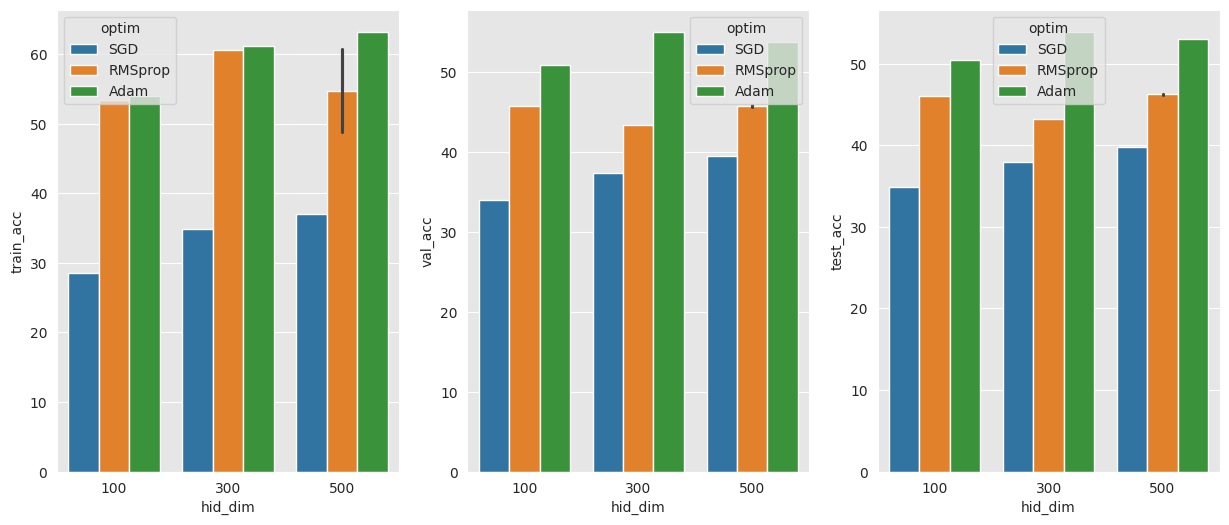

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='hid_dim', y='train_acc', hue='optim', data=df, ax=ax[0])
sns.barplot(x='hid_dim', y='val_acc', hue='optim', data=df, ax=ax[1])
sns.barplot(x='hid_dim', y='test_acc', hue='optim', data=df, ax=ax[2])


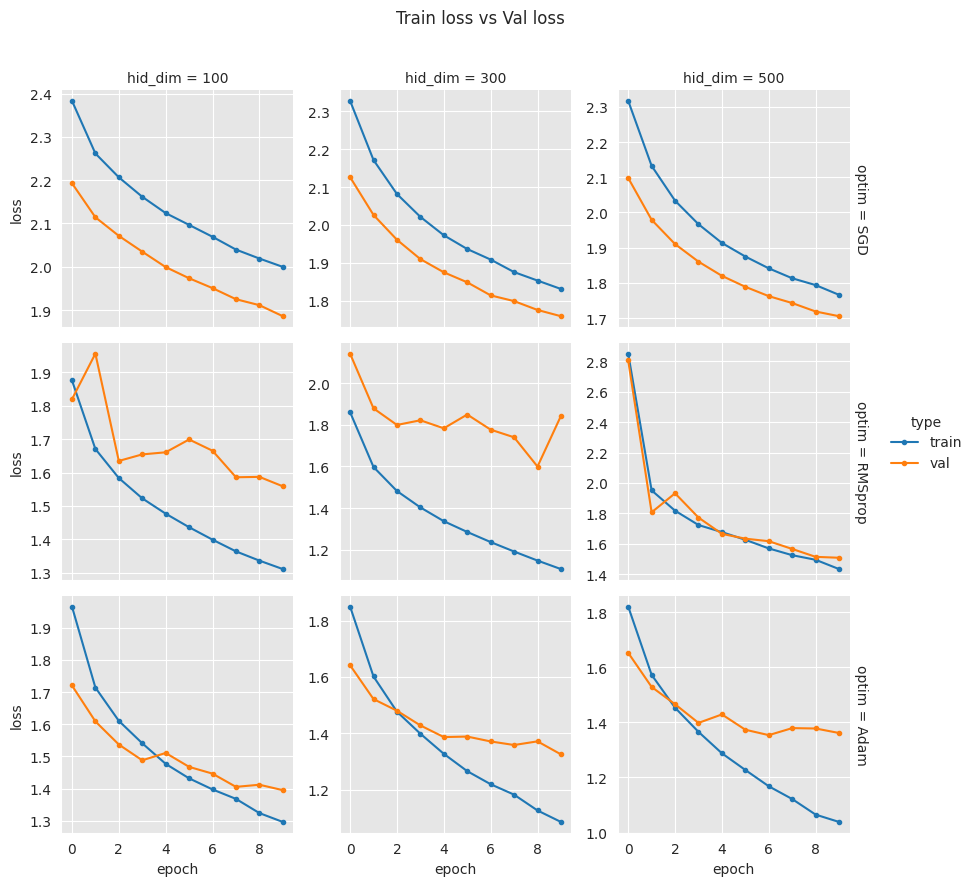

In [41]:
var1 = 'hid_dim'
var2 = 'optim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]

        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

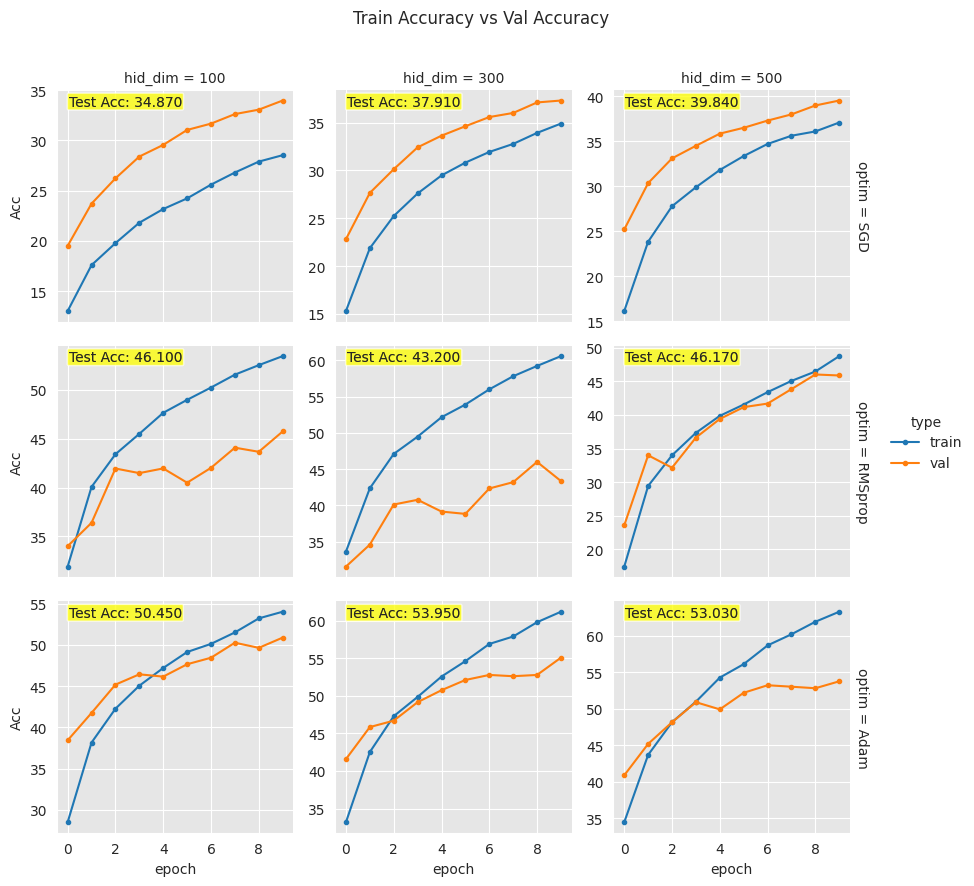

In [44]:
var1 = 'hid_dim'
var2 = 'optim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]

        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]

        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)